In [1]:
# Importing necessary libraries

import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importing datasets

dataset_path = '/content/drive/MyDrive/Rajalingam/fer2013/fer2013.csv'

df = pd.read_csv(dataset_path)

df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

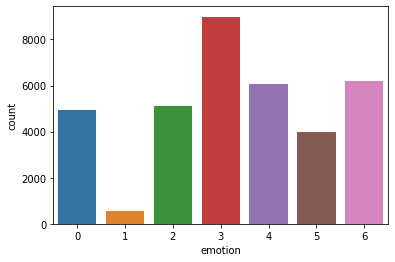

In [5]:
import seaborn as sns
sns.countplot(data=df, x = 'emotion')
plt.show()

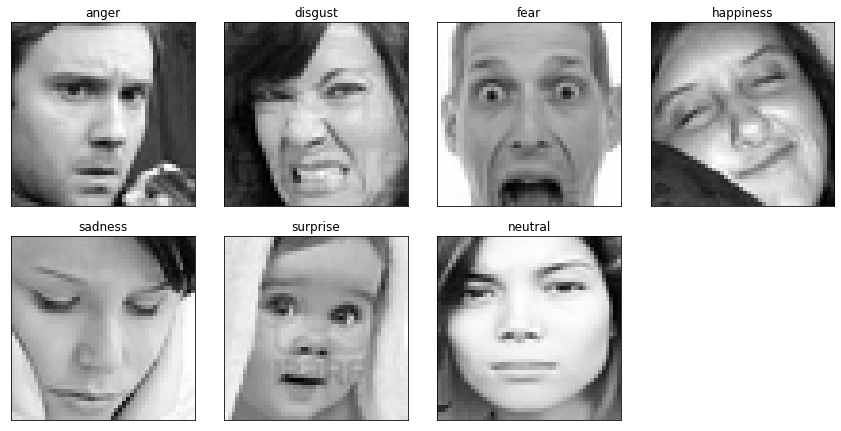

In [6]:
# Visualizing the datasets

emotions_dummy = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

fig = plt.figure(1, (12, 12))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(1):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(4, 4, k)
        ax.imshow(px , cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions_dummy[label])
        plt.tight_layout()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,Dropout, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [8]:
image_size=(48,48)

# Data Loading and Pre-Processing Functionalities

def load_dataset():
    data = pd.read_csv(dataset_path)
    data = (data[data['pixels'].notnull()])
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = (data['emotion'])#.values
    return faces, emotions
 
def preprocess_data(x):
    x = x.astype('float32')
    x = x / 255.0
    return x
 
#Data Augumentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        shear_range = 10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


In [9]:
faces, emotions = load_dataset()
faces = preprocess_data(faces)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

In [33]:
# Neural Network Definition

model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (5,5), input_shape = (Xtrain.shape[1:]), padding='same'))
model.add(Conv2D(64, kernel_size=(5,5), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(filters=128, kernel_size=(5,5), padding='same'))
model.add(Conv2D(128, kernel_size=(5,5), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same'))
model.add(Conv2D(256, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(7, activation='softmax'))

optimizer = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
activation_8 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 128)      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [36]:
# Callbacks

batch_size = 128
num_epochs = 10
verbose = 1
patience = 5


base_path = '/content/drive/MyDrive/Rajalingam/log'
log_file_path = base_path + '/emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=patience, verbose=1)
trained_models_path = base_path + '/weights'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

In [37]:
from tensorflow.keras.utils import to_categorical

history = model.fit(Xtrain, to_categorical(Ytrain), 
                    batch_size = batch_size, 
                    epochs = num_epochs, 
                    callbacks=callbacks,
                    validation_data= (Xtest, to_categorical(Ytest)))

Epoch 1/10
225/225 [==============================] - 16s 67ms/step - loss: 1.6395 - accuracy: 0.3804 - val_loss: 1.6992 - val_accuracy: 0.3331

Epoch 00001: val_loss improved from inf to 1.69920, saving model to /content/drive/MyDrive/Rajalingam/log/weights.01-0.33.hdf5
Epoch 2/10
225/225 [==============================] - 15s 67ms/step - loss: 1.3019 - accuracy: 0.5051 - val_loss: 1.4672 - val_accuracy: 0.4402

Epoch 00002: val_loss improved from 1.69920 to 1.46724, saving model to /content/drive/MyDrive/Rajalingam/log/weights.02-0.44.hdf5
Epoch 3/10
225/225 [==============================] - 15s 67ms/step - loss: 1.1429 - accuracy: 0.5690 - val_loss: 1.4992 - val_accuracy: 0.4402

Epoch 00003: val_loss did not improve from 1.46724
Epoch 4/10
225/225 [==============================] - 15s 67ms/step - loss: 1.0403 - accuracy: 0.6140 - val_loss: 1.2714 - val_accuracy: 0.5184

Epoch 00004: val_loss improved from 1.46724 to 1.27145, saving model to /content/drive/MyDrive/Rajalingam/log/w

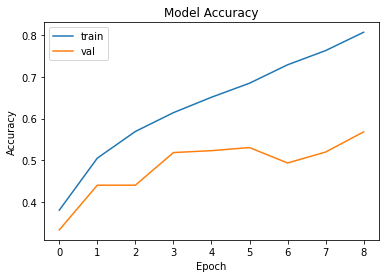

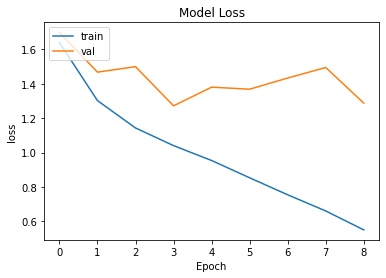

In [38]:
# Plotting Performance Metrics


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


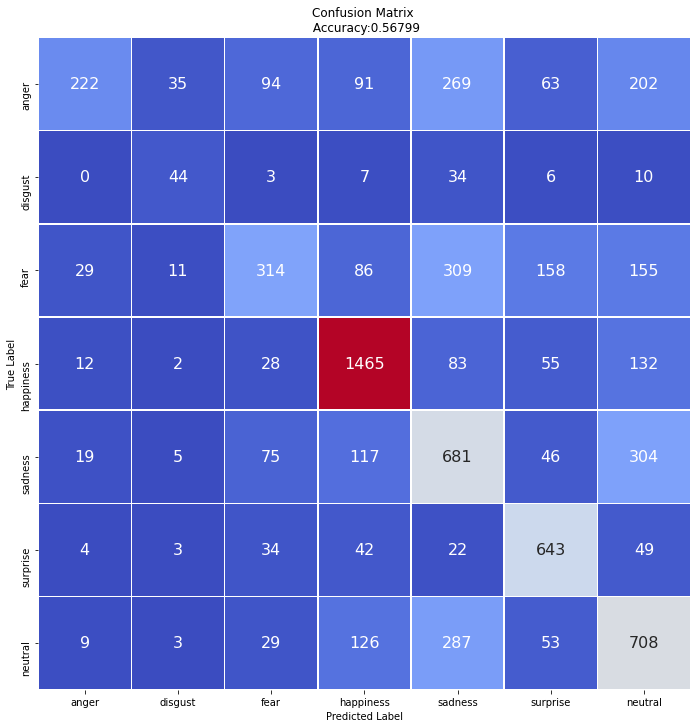

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

Ypred = model.predict_classes(Xtest)
y_test = to_categorical(Ytest).argmax(axis=-1)

cm = confusion_matrix(y_test, Ypred) 
LABELS = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']
cm_df = pd.DataFrame(cm, index = LABELS, columns = LABELS)

plt.figure(figsize=(12,12))
sns.heatmap(cm_df, annot=True, fmt="d", linewidths=0.5, cmap='coolwarm', cbar=False, annot_kws={'size':16}, square=True)
plt.title('Confusion Matrix \n Accuracy:{0:.5f}'.format(accuracy_score(y_test, Ypred)))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# VGG 16 with ImageDataGenerator

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, featurewise_center=False, featurewise_std_normalization=False, rotation_range=10, 
                                   width_shift_range=0.1, height_shift_range=0.1, zoom_range=.1, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [47]:
image_size=(48,48)

# Data Loading and Pre-Processing Functionalities

def load_dataset():
    data = pd.read_csv(dataset_path)
    data = (data[data['pixels'].notnull()])
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        face = np.stack((face,)*3, -1)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    #faces = np.expand_dims(faces, -1)
    emotions = (data['emotion'])#.values
    return faces, emotions
 
def preprocess_data(x):
    x = x.astype('float32')
    x = x / 255.0
    return x
 
#Data Augumentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        shear_range = 10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

faces, emotions = load_dataset()
faces = preprocess_data(faces)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

In [49]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (48,48, 3))

for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7,activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

opt = SGD(learning_rate=0.01)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['acc'])


In [52]:
batch_size = 128
num_epochs = 10

history = model.fit(train_datagen.flow(Xtrain, to_categorical(Ytrain)), 
                    steps_per_epoch = int (len(Xtrain) / batch_size), 
                    epochs = num_epochs, verbose=1,
                    validation_data = test_datagen.flow(Xtrain, to_categorical(Ytrain)), 
                    validation_steps = int (len(Xtest) / batch_size)
                    )


Epoch 1/10
224/224 [==============================] - 8s 35ms/step - loss: 1.8164 - acc: 0.2432 - val_loss: 1.8163 - val_acc: 0.2472
Epoch 2/10
224/224 [==============================] - 8s 34ms/step - loss: 1.8145 - acc: 0.2549 - val_loss: 1.8135 - val_acc: 0.2667
Epoch 3/10
224/224 [==============================] - 8s 35ms/step - loss: 1.8186 - acc: 0.2436 - val_loss: 1.8113 - val_acc: 0.2411
Epoch 4/10
224/224 [==============================] - 8s 34ms/step - loss: 1.8177 - acc: 0.2448 - val_loss: 1.8171 - val_acc: 0.2517
Epoch 5/10
224/224 [==============================] - 8s 35ms/step - loss: 1.8141 - acc: 0.2398 - val_loss: 1.7996 - val_acc: 0.2573
Epoch 6/10
224/224 [==============================] - 8s 35ms/step - loss: 1.8074 - acc: 0.2575 - val_loss: 1.7898 - val_acc: 0.2757
Epoch 7/10
224/224 [==============================] - 8s 35ms/step - loss: 1.8140 - acc: 0.2429 - val_loss: 1.7956 - val_acc: 0.2640
Epoch 8/10
224/224 [==============================] - 8s 35ms/step - 

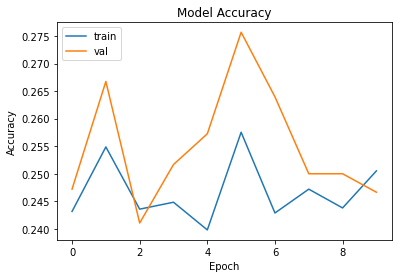

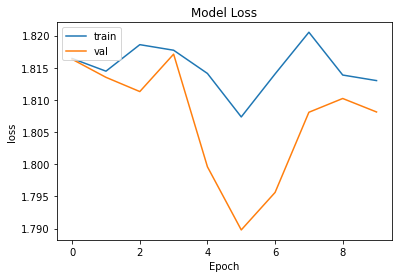

In [54]:
# Plotting Performance Metrics

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()